# 词向量

In [1]:
from gensim.models import KeyedVectors
import time

In [2]:
wv_model = KeyedVectors.load_word2vec_format('/Users/zn-nlp/Documents/project1_auto_master_qa/datasets/w2v.bin',
                                             binary=True)

In [3]:
def timeit(f):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        res = f(*args, **kwargs)
        end_time = time.time()
        print("%s函数运行时间为：%.8f" %(f.__name__, end_time - start_time))
        return res
    return wrapper

In [9]:
@timeit
def run():
    wv_model.wv.most_similar("维修")
run()

run函数运行时间为：0.11501217


/Users/zn-nlp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


使用gensim有以下缺点：

* gensim加载模型耗时很长

* 占用内存很大，会将所有的词向量加载进入内存，占用内存很大（>10g）

* most_similar函数耗时较长。gensim使用的算法似乎是暴力求解（待验证），耗时较长，0.35秒。

当词向量非常大的时候，如何提升搜索查找速度

In [10]:
import json

In [11]:
from collections import OrderedDict

In [12]:
word_index = OrderedDict()

In [13]:
for counter, key in enumerate(wv_model.vocab.keys()):
    word_index[key] = counter

In [14]:
with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

In [15]:
from annoy import AnnoyIndex

In [16]:
wv_index = AnnoyIndex(256)

/Users/zn-nlp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """Entry point for launching an IPython kernel.


In [17]:
i = 0

for key in wv_model.vocab.keys():
    v = wv_model[key]
    wv_index.add_item(i, v)
    i += 1

In [18]:
wv_index.build(10)

True

In [19]:
wv_index.save('wv_index_build10.index')

True

In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [21]:
for item in wv_index.get_nns_by_item(word_index[u'维修'], 11):
    print(reverse_word_index[item])

维修
修理
报掉
你常去
不在行
艾特
4s店
还保
拆大解
今行
指修


In [24]:
@timeit
def run():
    for item in wv_index.get_nns_by_item(word_index['维修'], 11):
        print(reverse_word_index[item])
run()

维修
修理
报掉
你常去
不在行
艾特
4s店
还保
拆大解
今行
指修
run函数运行时间为：0.00070095


# 1. RNN/LSTM/GRU

## 1.1 Bidirectional

paddlepaddle

In [ ]:
def bigru_layer(embedding):
    fc_forward = fluid.layers.fc(input=embedding, size=hidden_dim * 3, bias_attr=False)
    forward = fluid.layers.dynamic_gru(input=fc_forward,
                                       size=hidden_dim,
                                       param_attr=fluid.ParamAttr(name='gru_forward_encoder'))

    fc_backward = fluid.layers.fc(input=embedding, size=hidden_dim * 3, bias_attr=False)
    backward = fluid.layers.dynamic_gru(input=fc_backward,
                                        size=hidden_dim,
                                        param_attr=fluid.ParamAttr(name='gru_backward_encoder'),
                                        is_reverse=True)

    return forward, backward

dialogue_forward, dialogue_backward = bigru_layer(dialogue_embedding)
encoded_dialogue_vector = fluid.layers.concat(input=[dialogue_forward, dialogue_backward], axis=1)

tensorflow2.0

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.bigru = tf.keras.layers.Bidirectional(self.gru, merge_mode='concat')

    def call(self, x, hidden):
        x = self.embedding(x)
        hidden = tf.split(hidden, num_or_size_splits=2, axis=1)
        output, forward_state, backward_state = self.bigru(x, initial_state=hidden)
        state = tf.concat([forward_state, backward_state], axis=1)
        return state 

In [38]:
import tensorflow as tf

In [43]:
a = tf.ones([16, 200, 256])

In [44]:
a

<tf.Tensor: shape=(16, 200, 256), dtype=float32, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1.

## 1.2 Deep

paddlepaddle

In [ ]:
paddle.fluid.layers.stack(x, axis=0)

tensorflow2.0

In [ ]:
cells = [
    keras.layers.LSTMCell(output_dim),
    keras.layers.LSTMCell(output_dim),
    keras.layers.LSTMCell(output_dim),
]

inputs = keras.Input((timesteps, input_dim))
x = keras.layers.RNN(cells)(inputs)

# 2. Exploding and Vanishing Gradient Problem

## 2.1 Exploding Gradient

Dealing with Exploding Gradients
A solution to fix this is to apply gradient clipping; which places a predefined threshold on the gradients to prevent it from getting too large, and by doing this it doesn’t change the direction of the gradients it only change its length.
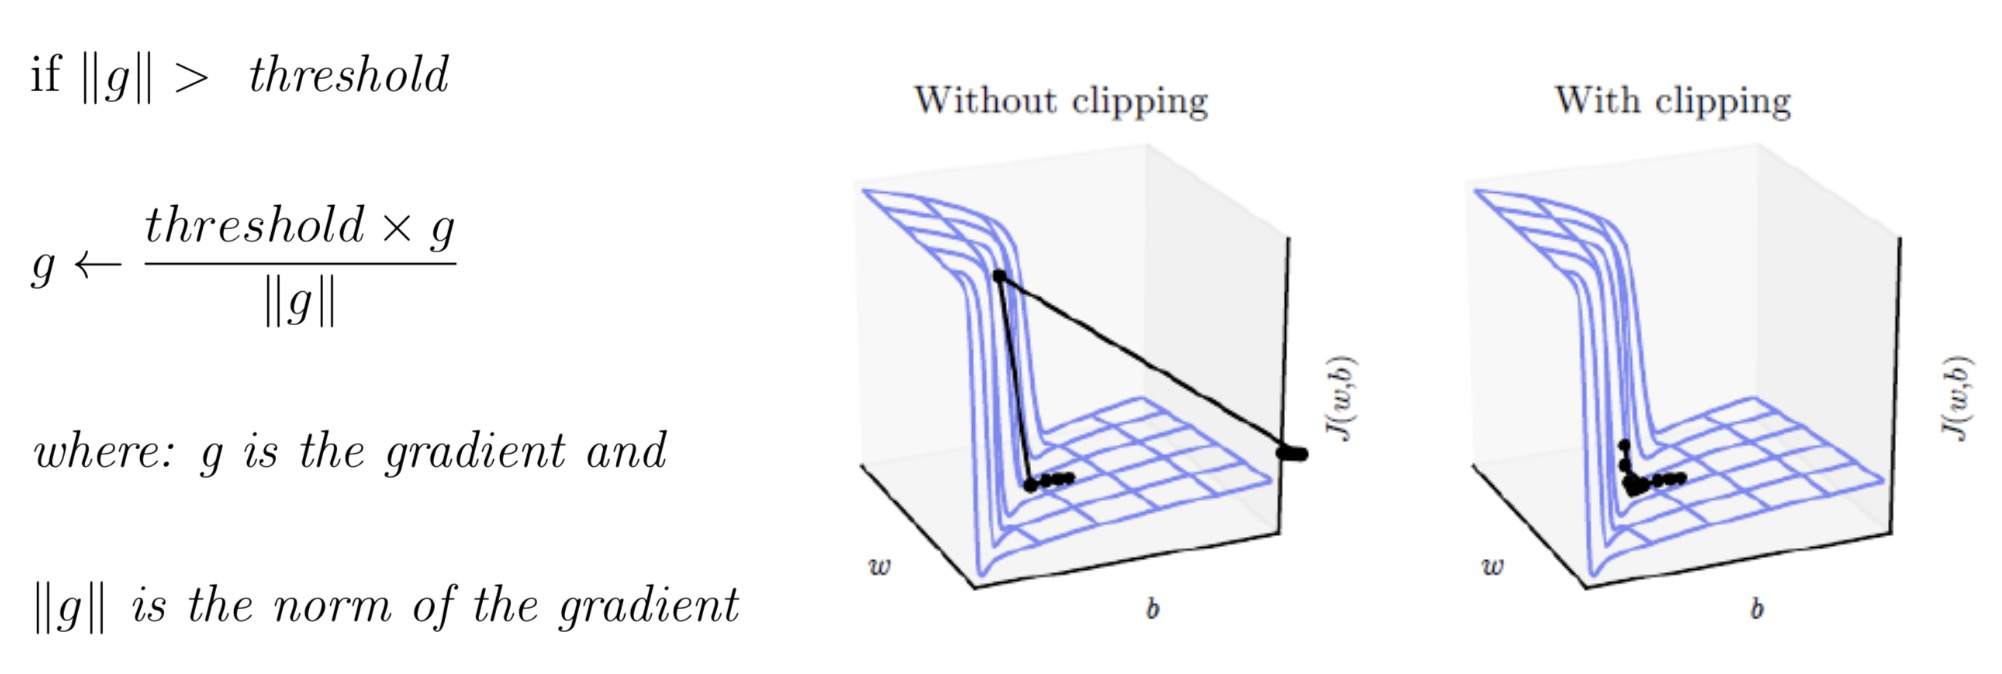

paddlepaddle

In [ ]:
def optimizer_func(hidden_dim):
    fluid.clip.set_gradient_clip(clip=fluid.clip.GradientClipByGlobalNorm(clip_norm=5.0))
    lr_decay = fluid.layers.learning_rate_scheduler.noam_decay(hidden_dim, 1000)
    return fluid.optimizer.Adam(learning_rate=lr_decay,
                                regularization=fluid.regularizer.L2DecayRegularizer(regularization_coeff=1e-4))

tensorflow2.0

In [ ]:
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)

from tensorflow.keras import optimizers
my_optimizer = optimizers.SGD(lr=0.0000001, clipnorm=5.0)

## 2.2 Vanishing Gradient

### 2.2.1 Identity Initialization
 
One simple solution for dealing with vanishing gradient is the identity RNN architecture; where the network weights are initialized to the identity matrix and the activation functions are all set to ReLU and this ends up encouraging the network computations to stay close to the identity function. This works well because when the error derivatives are being propagated backwards through time, they remain constants of either 0 or 1, hence aren’t likely to suffer from vanishing gradients.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

(-1, 1)

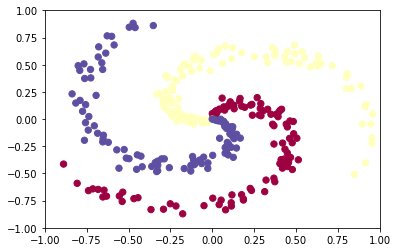

In [26]:
np.random.seed(0)
N = 100
D = 2
K = 3
X = np.zeros((N*K, D))
num_train_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [29]:
def sigmoid(x):
    x = 1/(1+np.exp(-x))
    return x

def sigmoid_grad(x):
    return (x)*(1-x)

def relu(x):
    return np.maximum(0, x)

In [30]:
def three_layer_net(NONLINEARITY, X, y, model, step_size, reg):
    h = model['h']
    h2 = model['h2']
    W1 = model['W1']
    W2 = model['W2']
    W3 = model['W3']
    b1 = model['b1']
    b2 = model['b2']
    b3 = model['b3']
    
    num_examples = X.shape[0]
    plot_array_1 = []
    plot_array_2 = []
    for i in range(50000):
        if NONLINEARITY == 'RELU':
            hidden_layer = relu(np.dot(X, W1) + b1)
            hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3
        
        elif NONLINEARITY == 'SIGM':
            hidden_layer = sigmoid(np.dot(X, W1) + b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3
        
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)+ 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print("iteration %d: loss %f" % (i, loss))
        
        dscores = probs
        dscores[range(num_examples), y] -= 1
        dscores /= num_examples
        
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)
        
        if NONLINEARITY == 'RELU':
            dhidden2 = np.dot(dscores, W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 = np.dot(hidden_layer.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = np.dot(dhidden2, W2.T)
            dhidden[hidden_layer <= 0] = 0
            
        elif NONLINEARITY == 'SIGM':
            dhidden2 = dscores.dot(W3.T)*sigmoid_grad(hidden_layer2)
            dW2 = (hidden_layer.T).dot(dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = dhidden2.dot(W2.T)*sigmoid_grad(hidden_layer)
            
        dW1 =  np.dot(X.T, dhidden)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden, axis=0)
        
        # add regularization
        dW3 += reg * W3
        dW2 += reg * W2
        dW1 += reg * W1
        
        #option to return loss, grads -- uncomment next comment
        grads = {}
        grads['W1'] = dW1
        grads['W2'] = dW2
        grads['W3'] = dW3
        grads['b1'] = db1
        grads['b2'] = db2
        grads['b3'] = db3
        #return loss, grads
        
        # update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
        
    # evaluate training set accuracy
    if NONLINEARITY == 'RELU':
        hidden_layer = relu(np.dot(X, W1) + b1)
        hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
    elif NONLINEARITY == 'SIGM':
        hidden_layer = sigmoid(np.dot(X, W1) + b1)
        hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
    
    scores = np.dot(hidden_layer2, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    print('training accuracy: %.2f' % (np.mean(predicted_class == y))) 
    #return cost, grads
    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3

In [31]:
#Initialize toy model, train sigmoid net

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
h = 50
h2 = 50
num_train_examples = X.shape[0]

model = {}
model['h'] = h # size of hidden layer 1
model['h2'] = h2 # size of hidden layer 2
model['W1'] = 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2'] = np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(sigm_array_1, sigm_array_2, s_W1, s_W2,s_W3, s_b1, s_b2,s_b3) = three_layer_net('SIGM', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.113935
iteration 1000: loss 1.095640
iteration 2000: loss 0.937046
iteration 3000: loss 0.842175
iteration 4000: loss 0.819177
iteration 5000: loss 0.815092
iteration 6000: loss 0.811192
iteration 7000: loss 0.806774
iteration 8000: loss 0.801156
iteration 9000: loss 0.792839
iteration 10000: loss 0.776796
iteration 11000: loss 0.734320
iteration 12000: loss 0.653909
iteration 13000: loss 0.586465
iteration 14000: loss 0.545581
iteration 15000: loss 0.519612
iteration 16000: loss 0.501965
iteration 17000: loss 0.489176
iteration 18000: loss 0.479472
iteration 19000: loss 0.472165
iteration 20000: loss 0.466755
iteration 21000: loss 0.462640
iteration 22000: loss 0.459332
iteration 23000: loss 0.456526
iteration 24000: loss 0.454039
iteration 25000: loss 0.451761
iteration 26000: loss 0.449632
iteration 27000: loss 0.447616
iteration 28000: loss 0.445697
iteration 29000: loss 0.443872
iteration 30000: loss 0.442148
iteration 31000: loss 0.440552
iteration 32000: loss

In [32]:
#Re-initialize model, train relu net

model = {}
model['h'] = h # size of hidden layer 1
model['h2'] = h2# size of hidden layer 2
model['W1'] = 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2'] = np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(relu_array_1, relu_array_2, r_W1, r_W2,r_W3, r_b1, r_b2,r_b3) = three_layer_net('RELU', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.108852
iteration 1000: loss 0.294098
iteration 2000: loss 0.154213
iteration 3000: loss 0.137443
iteration 4000: loss 0.131893
iteration 5000: loss 0.129002
iteration 6000: loss 0.126939
iteration 7000: loss 0.125329
iteration 8000: loss 0.124004
iteration 9000: loss 0.122933
iteration 10000: loss 0.122061
iteration 11000: loss 0.121325
iteration 12000: loss 0.120712
iteration 13000: loss 0.120180
iteration 14000: loss 0.119721
iteration 15000: loss 0.119317
iteration 16000: loss 0.118950
iteration 17000: loss 0.118623
iteration 18000: loss 0.118329
iteration 19000: loss 0.118064
iteration 20000: loss 0.117822
iteration 21000: loss 0.117599
iteration 22000: loss 0.117389
iteration 23000: loss 0.117185
iteration 24000: loss 0.116932
iteration 25000: loss 0.116696
iteration 26000: loss 0.116483
iteration 27000: loss 0.116247
iteration 28000: loss 0.116017
iteration 29000: loss 0.115807
iteration 30000: loss 0.115613
iteration 31000: loss 0.115427
iteration 32000: loss

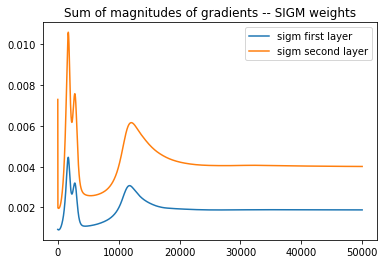

In [33]:
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend(("sigm first layer", "sigm second layer"))

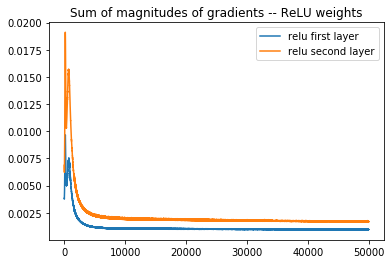

In [34]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.title('Sum of magnitudes of gradients -- ReLU weights')
plt.legend(("relu first layer", "relu second layer"))

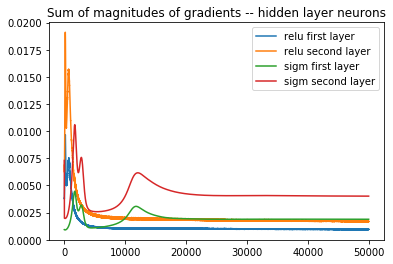

In [35]:
# Overlaying the two plots to compare
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- hidden layer neurons')
plt.legend(("relu first layer", "relu second layer","sigm first layer", "sigm second layer"))

(-1.8712034092398278, 1.8687965907601756)

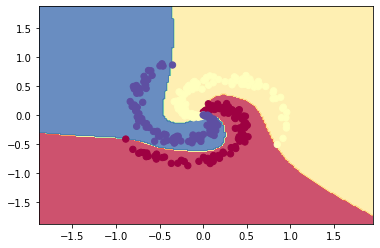

In [36]:
# plot the classifiers- SIGMOID
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(sigmoid(np.dot(sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], s_W1) + s_b1), s_W2) + s_b2), s_W3) + s_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

(-1.8712034092398278, 1.8687965907601756)

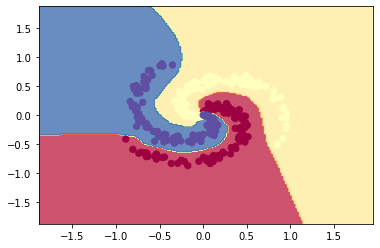

In [37]:
# plot the classifiers-- RELU
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(relu(np.dot(relu(np.dot(np.c_[xx.ravel(), yy.ravel()], r_W1) + r_b1), r_W2) + r_b2), r_W3) + r_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

### 2.2.2 LSTM

An even more popular and widely used solution is the Long Short-Term Memory architecture (LSTM); a variant of the regular recurrent network which was designed to make it easy to capture long-term dependencies in sequence data. The standard RNN operates in such a way that the hidden state activation are influenced by the other local activations closest to them, which corresponds to a “short-term memory”, while the network weights are influenced by the computations that take place over entire long sequences, which corresponds to a “long-term memory”. Hence the RNN was redesigned so that it has an activation state that can also act like weights and preserve information over long distances, hence the name “Long Short-Term Memory”.

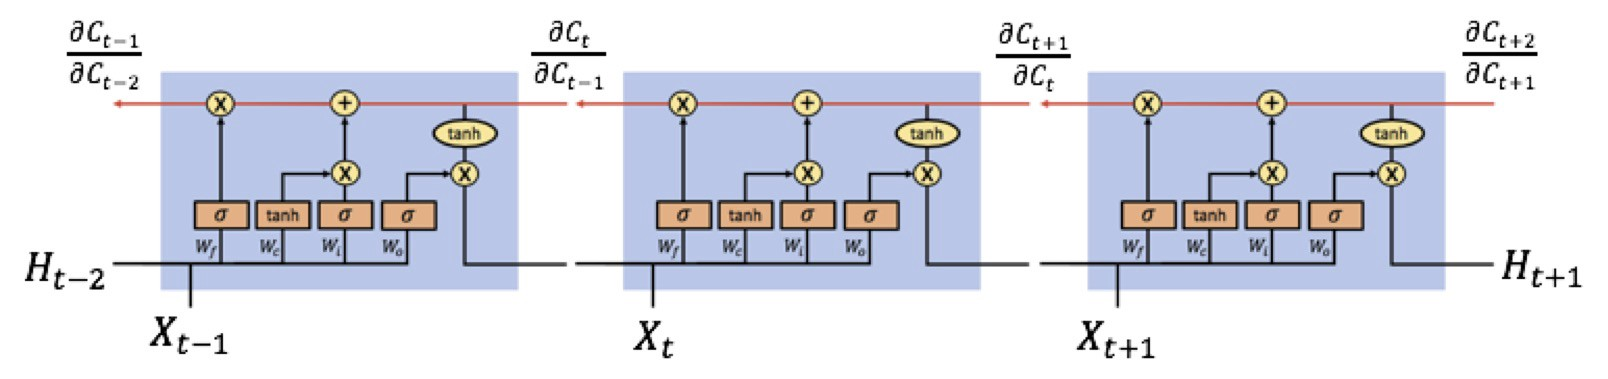

### 2.2.3 Residual Networks

Residual networks are another solution, as they provide residual connections straight to earlier layers. As seen in Image 2, the residual connection directly adds the value at the beginning of the block, x, to the end of the block (F(x)+x). This residual connection doesn’t go through activation functions that “squashes” the derivatives, resulting in a higher overall derivative of the block.

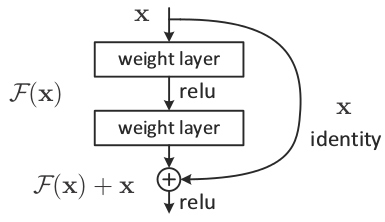

### 2.2.4 Batch Normalization

Finally, batch normalization layers can also resolve the issue. As stated before, the problem arises when a large input space is mapped to a small one, causing the derivatives to disappear. In Image 1, this is most clearly seen at when |x| is big. Batch normalization reduces this problem by simply normalizing the input so |x| doesn’t reach the outer edges of the sigmoid function. As seen in Image 3, it normalizes the input so that most of it falls in the green region, where the derivative isn’t too small.

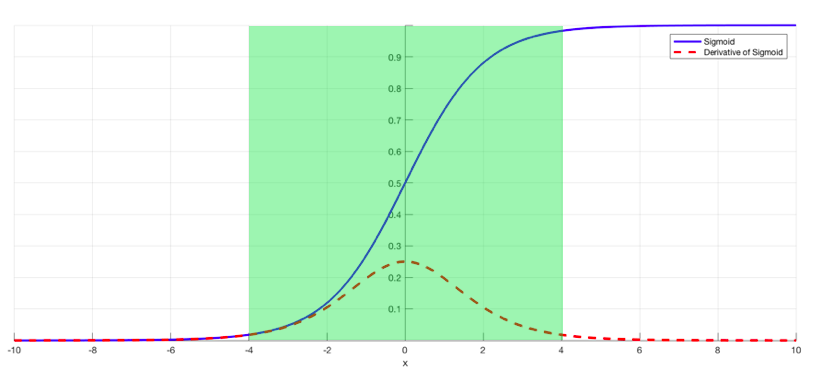

paddlepaddle

In [ ]:
import paddle.fluid as fluid
from paddle.fluid.dygraph.base import to_variable
import numpy as np

x = np.random.random(size=(3, 10, 3, 7)).astype('float32')
with fluid.dygraph.guard():
    x = to_variable(x)
    batch_norm = fluid.BatchNorm("batch_norm", 10)
    hidden1 = batch_norm(x)
    
name_scope, num_channels, act=None, is_test=False, momentum=0.9, epsilon=1e-05, param_attr=None, bias_attr=None, dtype='float32', data_layout='NCHW', in_place=False, moving_mean_name=None, moving_variance_name=None, do_model_average_for_mean_and_var=False, use_global_stats=False, trainable_statistics=False

tensorflow2.0

In [ ]:
from tensorflow import keras

keras.layers.BatchNormalization(axis=-1,
                                momentum=0.99,
                                epsilon=0.001,
                                center=True,
                                scale=True,
                                beta_initializer='zeros',
                                gamma_initializer='ones',
                                moving_mean_initializer='zeros',
                                moving_variance_initializer='ones',
                                beta_regularizer=None,
                                gamma_regularizer=None,
                                beta_constraint=None,
                                gamma_constraint=None)


# 3 LSTM/GRU

paddlepaddle

In [ ]:
paddle.fluid.layers.lstm(input,
                         init_h,
                         init_c,
                         max_len,
                         hidden_size,
                         num_layers,
                         dropout_prob=0.0,
                         is_bidirec=False,
                         is_test=False,
                         name=None,
                         default_initializer=None,
                         seed=-1)

In [ ]:
rnn_out, last_h, last_c = layers.lstm(emb,
                                      init_h,
                                      init_c,
                                      max_len,
                                      hidden_size,
                                      num_layers,
                                      dropout_prob=dropout_prob)

In [ ]:
hidden = fluid.layers.dynamic_gru(input=x, size=hidden_dim)

tensorflow2.0

In [ ]:
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM(200,
                                                           return_state=True )

# 4. Encoder-Decoder结构

paddlepaddle

In [ ]:
import paddle.fluid as fluid
import numpy as np

class MyLayer(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(MyLayer, self).__init__(name_scope)
        self.fc = fluid.dygraph.nn.FC(self.full_name(), size=12)
    
    def forward(self, inputs):
        x = self.fc(inputs)
        x = fluid.layers.relu(x)
        self._x_for_debug = x
        x = fluid.layers.elementwise_mul(x, x)
        x = fluid.layers.reduce_sum(x)
        return [x]

tensorflow2.0

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            self.gru = tf.keras.layers.CuDNNGRU(self.enc_units,
                                                return_sequences=True,
                                                return_state=True,
                                                recurrent_initializer='glorot_uniform')
        else:
            self.gru = tf.keras.layers.GRU(self.enc_units,
                                           return_sequences=True,
                                           return_state=True,
                                           recurrent_initializer='glorot_uniform')
        # self.bigru = tf.keras.layers.Bidirectional(self.gru, merge_mode='concat')

    def call(self, x, hidden):
        x = self.embedding(x)
        # hidden = tf.split(hidden, num_or_size_splits=2, axis=1)
        # output, forward_state, backward_state = self.bigru(x, initial_state=hidden)
        # state = tf.concat([forward_state, backward_state], axis=1)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
import pandas as pd

In [ ]:
A = pd.DataFrame({'key':['']})